# Hyperparameters

In [1]:
batch_size = 4
epochs = 20
device = 'cuda'
# device = 'cpu'
h_crop = 192
w_crop = 256

# Utils

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.nn.init import kaiming_normal_, constant_
from torchvision.transforms import functional as TF
from torchvision import transforms
from spatial_correlation_sampler import spatial_correlation_sample
from torchvision.utils import flow_to_image

from imageio.v3 import imread
import numpy as np
import os
from typing import Callable, Optional
import time
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt

In [3]:
def get_flying_chairs_data_paths(root: str):
    samples = []
    for name in sorted(os.listdir(root)):
        if name.endswith('_flow.flo'):
            sample_id = name[: -9]
            img1 = os.path.join(root, sample_id + "_img1.ppm")
            img2 = os.path.join(root, sample_id + "_img2.ppm")
            flow = os.path.join(root, name)
            samples.append([[img1, img2], flow])

    return samples


def flying_chairs_loader(sample):
    inputs, target = sample[0], sample[1]
    img1, img2 = np.asarray(imread(inputs[0]), dtype=np.float32), np.asarray(imread(inputs[1]), dtype=np.float32)

    with open(target, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        assert (202021.25 == magic), 'Magic number incorrect. Invalid .flo file'
        h = np.fromfile(f, np.int32, count=1)[0]
        w = np.fromfile(f, np.int32, count=1)[0]
        data = np.fromfile(f, np.float32, count=2 * w * h)
    # Reshape data into 3D array (columns, rows, bands)
    data2D = np.resize(data, (w, h, 2))
    return [img1, img2], data2D


def make_dataset_split(dataset: [], split: float = 0.8, random_seed: int = 42):
    num_train_samples = int(len(dataset) * split)
    num_val_samples = len(dataset) - num_train_samples

    seed = torch.Generator().manual_seed(random_seed)
    return data.random_split(dataset, [num_train_samples, num_val_samples], generator=seed)


def mean_epe(input_flow, target_flow):
    return torch.norm(target_flow - input_flow, p=2, dim=1).mean()

# Loader

In [4]:
class CustomDataset(Dataset):
    def __init__(self, file_names: [str],
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 loader=flying_chairs_loader
                 ):
        self.file_names = file_names
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, idx):
        inputs, target = self.loader(self.file_names[idx])
        if self.transform:
            inputs[0] = self.transform(inputs[0])
            inputs[1] = self.transform(inputs[1])
        if self.target_transform:
            target = self.target_transform(target)
        return inputs, target

    def __len__(self):
        return len(self.file_names)

# FlowNet

In [5]:
def conv(batchNorm, in_planes, out_planes, kernel_size=3, stride=1):
    if batchNorm:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(0.1,inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=True),
            nn.LeakyReLU(0.1,inplace=True)
        )


def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=False)


def deconv(in_planes, out_planes):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.1,inplace=True)
    )


def correlate(input1, input2):
    out_corr = spatial_correlation_sample(input1,
                                          input2,
                                          kernel_size=1,
                                          patch_size=21,
                                          stride=1,
                                          padding=0,
                                          dilation_patch=2)
    b, ph, pw, h, w = out_corr.size()
    out_corr = out_corr.view(b, ph * pw, h, w)/input1.size(1)
    return F.leaky_relu_(out_corr, 0.1)


def crop_like(input, target):
    if input.size()[2:] == target.size()[2:]:
        return input
    else:
        return input[:, :, :target.size(2), :target.size(3)]


class FlowNetS(nn.Module):
    expansion = 1

    def __init__(self,batchNorm=False):
        super(FlowNetS,self).__init__()

        self.batchNorm = batchNorm
        self.conv1   = conv(self.batchNorm,   6,   64, kernel_size=7, stride=2)
        self.conv2   = conv(self.batchNorm,  64,  128, kernel_size=5, stride=2)
        self.conv3   = conv(self.batchNorm, 128,  256, kernel_size=5, stride=2)
        self.conv3_1 = conv(self.batchNorm, 256,  256)
        self.conv4   = conv(self.batchNorm, 256,  512, stride=2)
        self.conv4_1 = conv(self.batchNorm, 512,  512)
        self.conv5   = conv(self.batchNorm, 512,  512, stride=2)
        self.conv5_1 = conv(self.batchNorm, 512,  512)
        self.conv6   = conv(self.batchNorm, 512, 1024, stride=2)
        self.conv6_1 = conv(self.batchNorm,1024, 1024)

        self.deconv5 = deconv(1024,512)
        self.deconv4 = deconv(1026,256)
        self.deconv3 = deconv(770,128)
        self.deconv2 = deconv(386,64)

        self.predict_flow6 = predict_flow(1024)
        self.predict_flow5 = predict_flow(1026)
        self.predict_flow4 = predict_flow(770)
        self.predict_flow3 = predict_flow(386)
        self.predict_flow2 = predict_flow(194)

        self.upsampled_flow6_to_5 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                kaiming_normal_(m.weight, 0.1)
                if m.bias is not None:
                    constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                constant_(m.weight, 1)
                constant_(m.bias, 0)

    def forward(self, x):
        out_conv2 = self.conv2(self.conv1(x))
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))

        flow6       = self.predict_flow6(out_conv6)
        flow6_up    = crop_like(self.upsampled_flow6_to_5(flow6), out_conv5)
        out_deconv5 = crop_like(self.deconv5(out_conv6), out_conv5)

        concat5 = torch.cat((out_conv5,out_deconv5,flow6_up),1)
        flow5       = self.predict_flow5(concat5)
        flow5_up    = crop_like(self.upsampled_flow5_to_4(flow5), out_conv4)
        out_deconv4 = crop_like(self.deconv4(concat5), out_conv4)

        concat4 = torch.cat((out_conv4,out_deconv4,flow5_up),1)
        flow4       = self.predict_flow4(concat4)
        flow4_up    = crop_like(self.upsampled_flow4_to_3(flow4), out_conv3)
        out_deconv3 = crop_like(self.deconv3(concat4), out_conv3)

        concat3 = torch.cat((out_conv3,out_deconv3,flow4_up),1)
        flow3       = self.predict_flow3(concat3)
        flow3_up    = crop_like(self.upsampled_flow3_to_2(flow3), out_conv2)
        out_deconv2 = crop_like(self.deconv2(concat3), out_conv2)

        concat2 = torch.cat((out_conv2,out_deconv2,flow3_up),1)
        flow2 = self.predict_flow2(concat2)

        if self.training:
            return flow2,flow3,flow4,flow5,flow6
        else:
            return flow2

    def weight_parameters(self):
        return [param for name, param in self.named_parameters() if 'weight' in name]

    def bias_parameters(self):
        return [param for name, param in self.named_parameters() if 'bias' in name]



In [6]:
def EPE(input_flow, target_flow, sparse=False, mean=True):
    EPE_map = torch.norm(target_flow-input_flow,2,1)
    batch_size = EPE_map.size(0)
    if sparse:
        # invalid flow is defined with both flow coordinates to be exactly 0
        mask = (target_flow[:,0] == 0) & (target_flow[:,1] == 0)

        EPE_map = EPE_map[~mask]
    if mean:
        return EPE_map.mean()
    else:
        return EPE_map.sum()/batch_size


def sparse_max_pool(input, size):
    positive = (input > 0).float()
    negative = (input < 0).float()
    output = F.adaptive_max_pool2d(input * positive, size) - F.adaptive_max_pool2d(-input * negative, size)
    return output


def multiscaleEPE(network_output, target_flow, weights=None, sparse=False):
    def one_scale(output, target, sparse):

        b, _, h, w = output.size()

        if sparse:
            target_scaled = sparse_max_pool(target, (h, w))
        else:
            target_scaled = F.interpolate(target, (h, w), mode='area')
        return EPE(output, target_scaled, sparse, mean=False)

    if type(network_output) not in [tuple, list]:
        network_output = [network_output]
    if weights is None:
        weights = [0.005, 0.01, 0.02, 0.08, 0.32]  # as in original article
    assert(len(weights) == len(network_output))

    loss = 0
    for output, weight in zip(network_output, weights):
        loss += weight * one_scale(output, target_flow, sparse)
    return loss


def realEPE(output, target, sparse=False):
    b, _, h, w = target.size()
    upsampled_output = F.interpolate(output, (h,w), mode='bilinear', align_corners=False)
    return EPE(upsampled_output, target, sparse, mean=True)

# Train

In [7]:
def train(train_loader, model, optimizer):
    train_losses_multiscale_epe = []
    train_losses_real_epe = []
    
    model.train()

    for i, (input, target) in enumerate(tqdm(train_loader)):
        target = target.to(device)
        input = torch.cat(input,1).to(device)

        output = model(input)
        h, w = target.size()[-2:]
        output = [F.interpolate(output[0], (h,w)), *output[1:]]

        loss = multiscaleEPE(output, target)
        loss_real = realEPE(output[0], target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses_multiscale_epe.append(loss)
        train_losses_real_epe.append(loss_real)

    return np.mean([tensor.cpu().detach().numpy() for tensor in train_losses_multiscale_epe]), np.mean([tensor.cpu().detach().numpy() for tensor in train_losses_real_epe])


def validate(val_loader, model):
    val_losses_epe = []
    
    model.eval()

    for input, target in tqdm(val_loader):
        target = target.to(device)
        input = torch.cat(input,1).to(device)

        output = model(input)
        val_losses_epe.append(realEPE(output, target))
        
    return np.mean([tensor.cpu().numpy() for tensor in val_losses_epe])

In [9]:
model = FlowNetS()

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([h_crop,w_crop], interpolation=transforms.InterpolationMode.NEAREST)
])
train_target_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([h_crop,w_crop], interpolation=transforms.InterpolationMode.NEAREST)
])

train_val_dataset = CustomDataset(get_flying_chairs_data_paths('dataset'), 
                                  transform=train_transform,                 
                                  target_transform=train_target_transform)
train_dataset, val_dataset = make_dataset_split(train_val_dataset, split=0.8, random_seed=21)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


if device == 'cuda':
    model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

best_epe = float('inf')
train_epes = []
val_epes = []

save_path = 'flying_chairs_pretrained'
if not os.path.exists(save_path):
    os.makedirs(save_path)

for epoch in range(epochs):
    torch.cuda.empty_cache()
    gc.collect()
    tic = time.time()
    
    train_loss_multiscale_epe, train_loss_real_epe = train(train_loader, model, optimizer)
    
    with torch.no_grad():
        val_loss_epe = validate(val_loader, model)
    toc = time.time()
    
    train_epes.append(train_loss_real_epe)
    val_epes.append(val_loss_epe)
    
    print("Epoch:{}/{}..".format(epoch+1, epochs),
          "Train Loss Multiscale EPE: {:.3f}..".format(train_loss_multiscale_epe),
          "Train Loss Real EPE: {:.3f}..".format(train_loss_real_epe),
          "Val Loss EPE: {:.3f}..".format(val_loss_epe),
          "Time: {:.2f}m".format((toc-tic)/60))

    is_best = val_loss_epe < best_epe
    best_epe = min(val_loss_epe, best_epe)
    if is_best:
        torch.save(model, 'best_flownet.pt')
print(f'Best val epe = {best_epe}')

100%|██████████| 75/75 [00:03<00:00, 19.24it/s]


Epoch:1/20.. Train Loss Multiscale EPE: 7864.891.. Train Loss Real EPE: 30.574.. Val Loss EPE: 16.538.. Time: 0.39m


100%|██████████| 75/75 [00:03<00:00, 19.95it/s]


Epoch:2/20.. Train Loss Multiscale EPE: 4660.135.. Train Loss Real EPE: 18.034.. Val Loss EPE: 13.838.. Time: 0.37m


100%|██████████| 75/75 [00:03<00:00, 19.60it/s]


Epoch:3/20.. Train Loss Multiscale EPE: 3734.803.. Train Loss Real EPE: 14.329.. Val Loss EPE: 13.193.. Time: 0.37m


100%|██████████| 75/75 [00:03<00:00, 19.67it/s]


Epoch:4/20.. Train Loss Multiscale EPE: 3401.063.. Train Loss Real EPE: 13.001.. Val Loss EPE: 11.871.. Time: 0.37m


100%|██████████| 75/75 [00:03<00:00, 19.85it/s]


Epoch:5/20.. Train Loss Multiscale EPE: 3198.948.. Train Loss Real EPE: 12.195.. Val Loss EPE: 11.520.. Time: 0.37m


100%|██████████| 75/75 [00:03<00:00, 19.98it/s]


Epoch:6/20.. Train Loss Multiscale EPE: 3039.515.. Train Loss Real EPE: 11.576.. Val Loss EPE: 10.495.. Time: 0.37m


100%|██████████| 75/75 [00:03<00:00, 19.56it/s]


Epoch:7/20.. Train Loss Multiscale EPE: 2867.589.. Train Loss Real EPE: 10.916.. Val Loss EPE: 10.494.. Time: 0.37m


100%|██████████| 75/75 [00:03<00:00, 19.46it/s]


Epoch:8/20.. Train Loss Multiscale EPE: 2752.376.. Train Loss Real EPE: 10.470.. Val Loss EPE: 10.964.. Time: 0.37m


100%|██████████| 75/75 [00:07<00:00, 10.15it/s]


Epoch:9/20.. Train Loss Multiscale EPE: 2668.865.. Train Loss Real EPE: 10.153.. Val Loss EPE: 10.596.. Time: 0.56m


100%|██████████| 75/75 [00:07<00:00, 10.27it/s]


Epoch:10/20.. Train Loss Multiscale EPE: 2530.033.. Train Loss Real EPE: 9.623.. Val Loss EPE: 10.442.. Time: 0.71m


100%|██████████| 75/75 [00:07<00:00, 10.14it/s]


Epoch:11/20.. Train Loss Multiscale EPE: 2476.659.. Train Loss Real EPE: 9.420.. Val Loss EPE: 9.986.. Time: 0.71m


100%|██████████| 75/75 [00:07<00:00, 10.24it/s]


Epoch:12/20.. Train Loss Multiscale EPE: 2270.416.. Train Loss Real EPE: 8.629.. Val Loss EPE: 9.597.. Time: 0.71m


100%|██████████| 75/75 [00:07<00:00, 10.07it/s]


Epoch:13/20.. Train Loss Multiscale EPE: 2215.153.. Train Loss Real EPE: 8.427.. Val Loss EPE: 9.123.. Time: 0.71m


100%|██████████| 75/75 [00:07<00:00,  9.95it/s]


Epoch:14/20.. Train Loss Multiscale EPE: 2121.624.. Train Loss Real EPE: 8.072.. Val Loss EPE: 9.166.. Time: 0.72m


100%|██████████| 75/75 [00:07<00:00, 10.07it/s]


Epoch:15/20.. Train Loss Multiscale EPE: 1996.918.. Train Loss Real EPE: 7.598.. Val Loss EPE: 9.798.. Time: 0.72m


100%|██████████| 75/75 [00:07<00:00, 10.22it/s]


Epoch:16/20.. Train Loss Multiscale EPE: 1894.583.. Train Loss Real EPE: 7.211.. Val Loss EPE: 9.288.. Time: 0.71m


100%|██████████| 75/75 [00:07<00:00, 10.35it/s]


Epoch:17/20.. Train Loss Multiscale EPE: 1850.047.. Train Loss Real EPE: 7.041.. Val Loss EPE: 8.727.. Time: 0.70m


100%|██████████| 75/75 [00:07<00:00, 10.36it/s]


Epoch:18/20.. Train Loss Multiscale EPE: 1718.653.. Train Loss Real EPE: 6.538.. Val Loss EPE: 9.056.. Time: 0.71m


100%|██████████| 75/75 [00:07<00:00, 10.48it/s]


Epoch:19/20.. Train Loss Multiscale EPE: 1652.916.. Train Loss Real EPE: 6.291.. Val Loss EPE: 8.841.. Time: 0.71m


100%|██████████| 75/75 [00:07<00:00, 10.23it/s]

Epoch:20/20.. Train Loss Multiscale EPE: 1602.508.. Train Loss Real EPE: 6.100.. Val Loss EPE: 9.049.. Time: 0.71m
Best val epe = 8.726587295532227


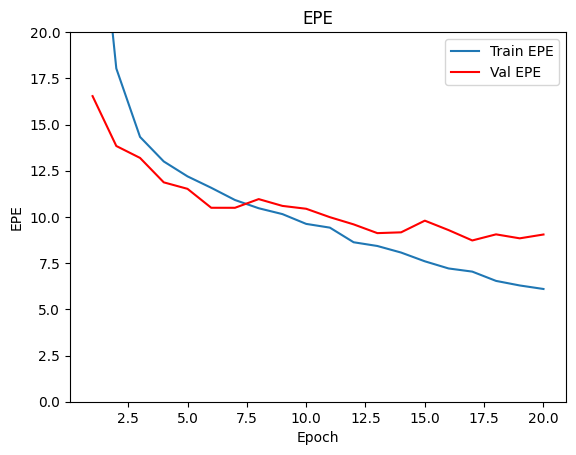

In [12]:
plt.title("EPE")
plt.xlabel('Epoch')
plt.ylabel('EPE')
plt.plot(list(range(1, len(train_epes)+1)), train_epes, label="Train EPE")
plt.plot(list(range(1, len(val_epes)+1)), val_epes, color='r', label="Val EPE")
plt.ylim((0, 20))
plt.legend()
plt.savefig("epes.png")

# Test

In [65]:
test_epes = []
model = torch.load("best_flownet.pt")

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([h_crop,w_crop], interpolation=transforms.InterpolationMode.NEAREST)
])
train_target_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([h_crop,w_crop], interpolation=transforms.InterpolationMode.NEAREST)
])

test_dataset = CustomDataset(get_flying_chairs_data_paths('test'), 
                                  transform=train_transform,                 
                                  target_transform=train_target_transform)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    test_losses_epes = []
    
    model.eval()

    for input, target in test_loader:
        target = target.to(device)
        input = torch.cat(input,1).to(device)

        output = model(input)
        test_epes.append(realEPE(output, target).cpu().numpy())

print(f'Test mean EPE = {np.mean(test_epes)}')

Test mean EPE = 7.341030120849609


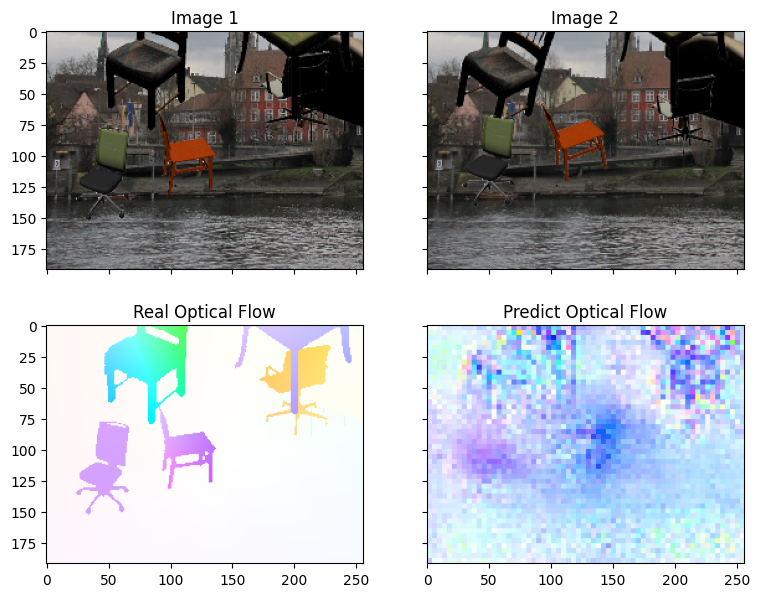

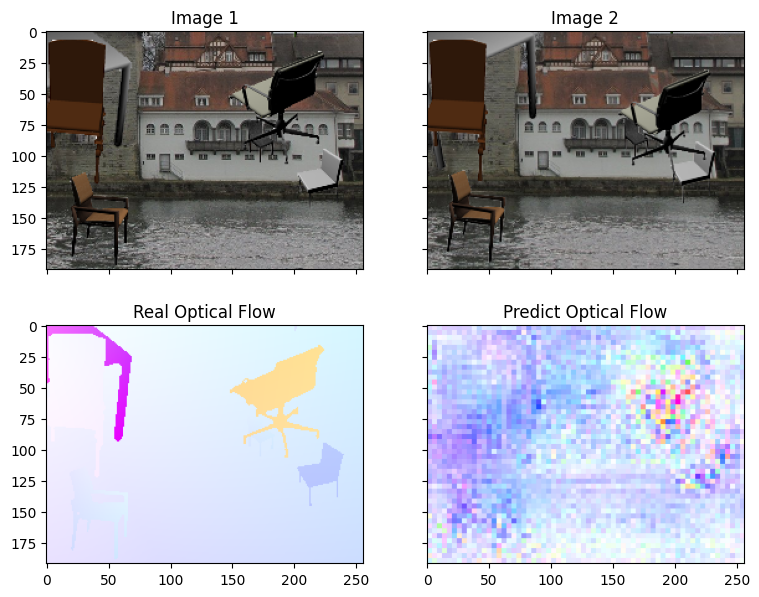

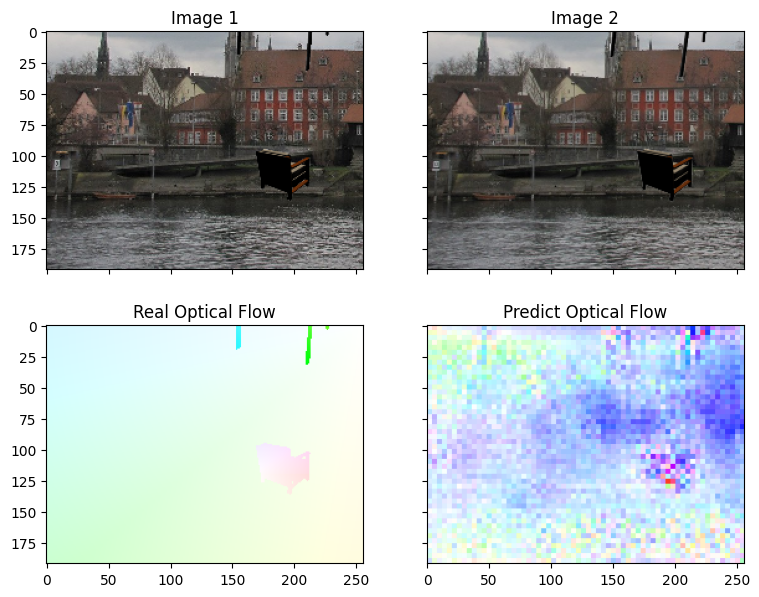

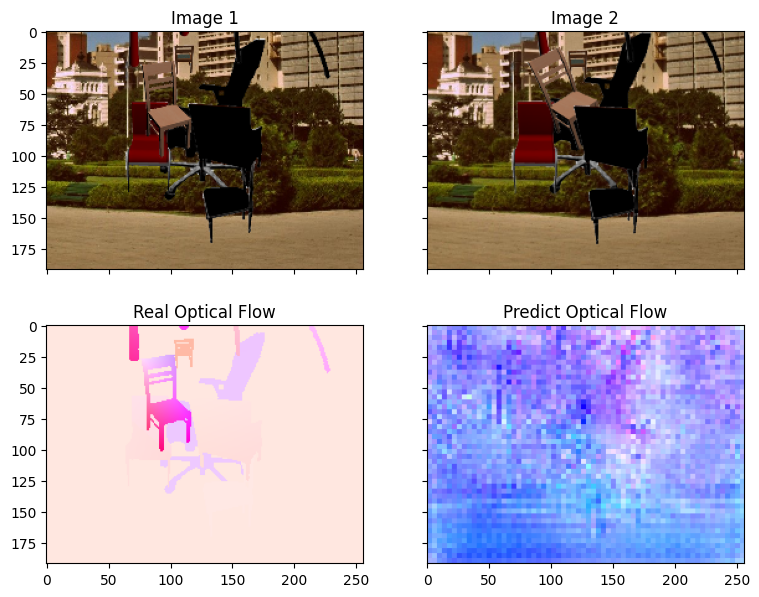

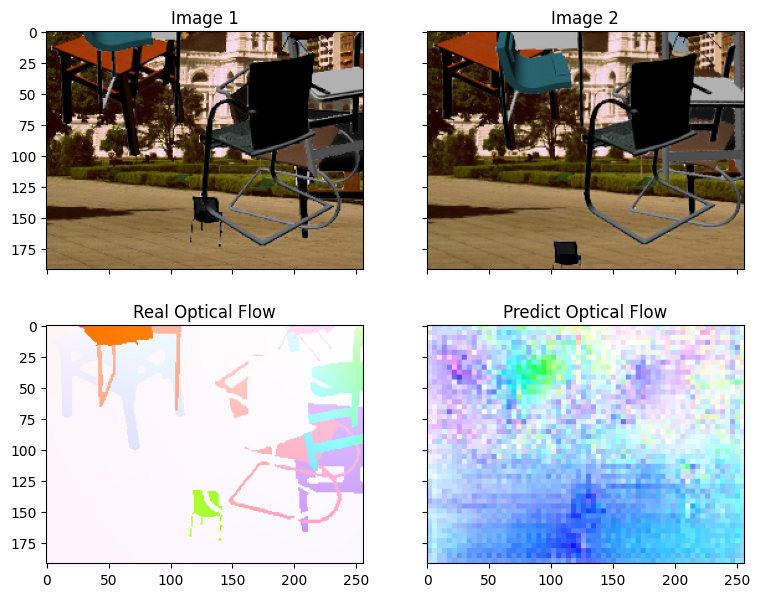

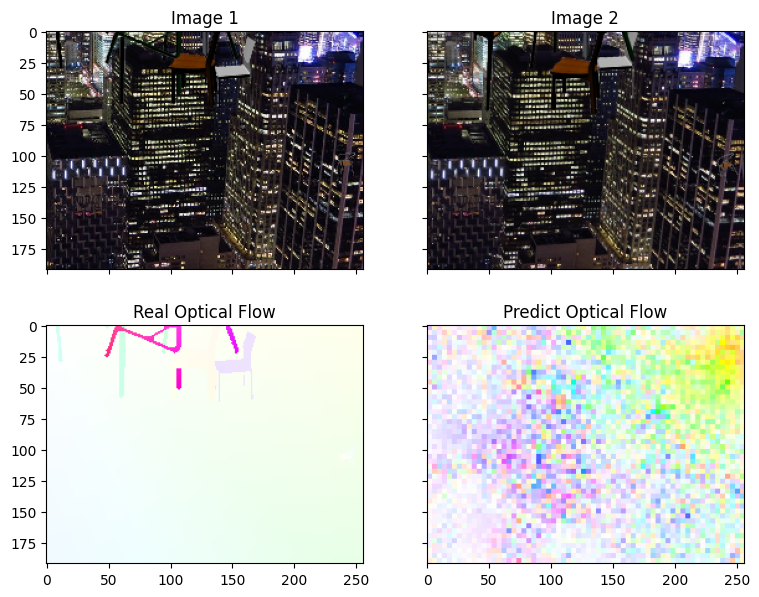

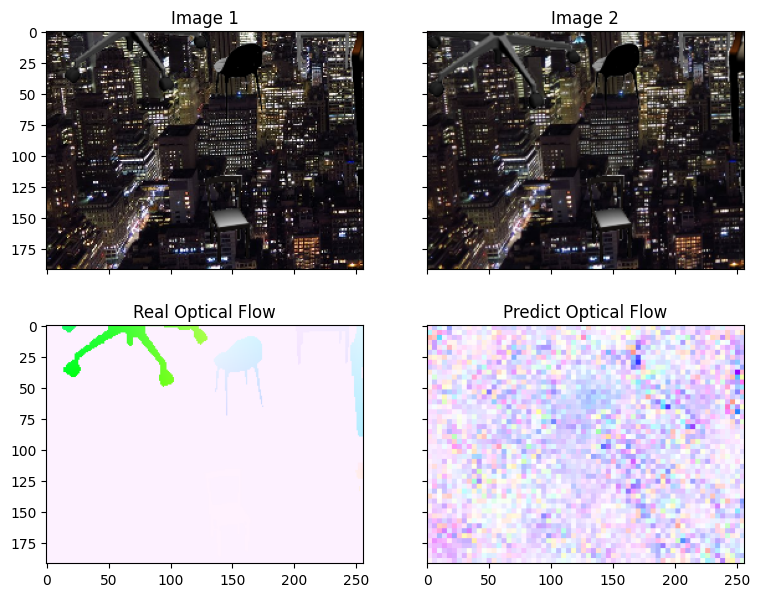

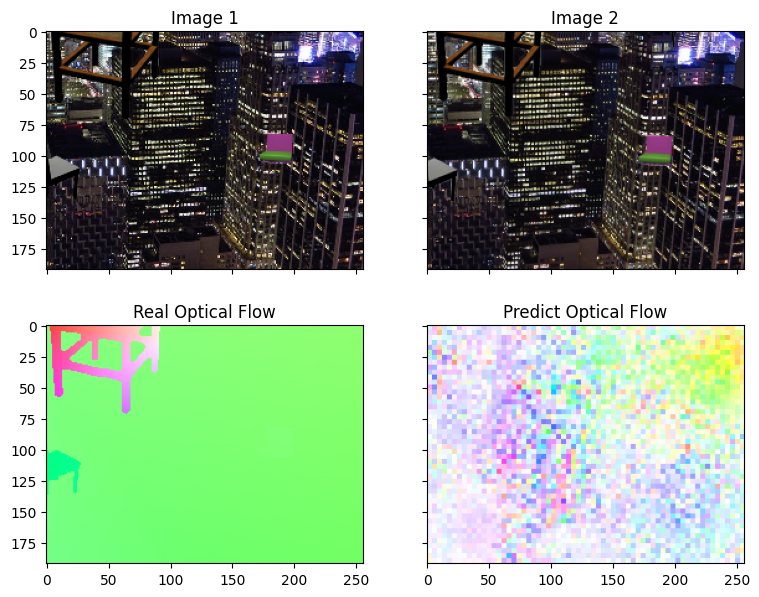

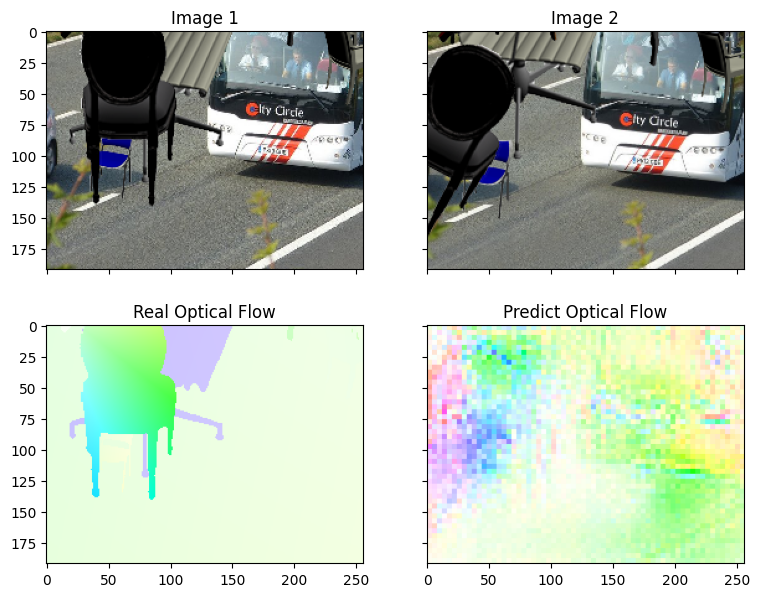

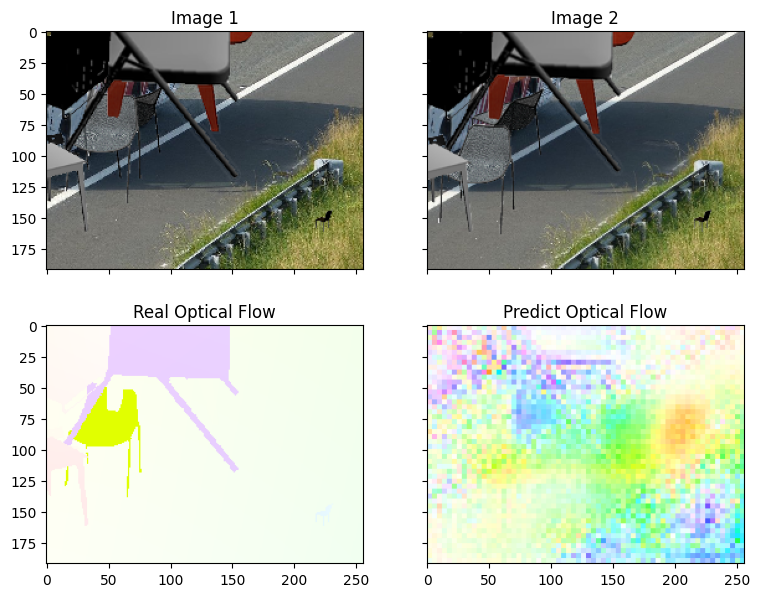

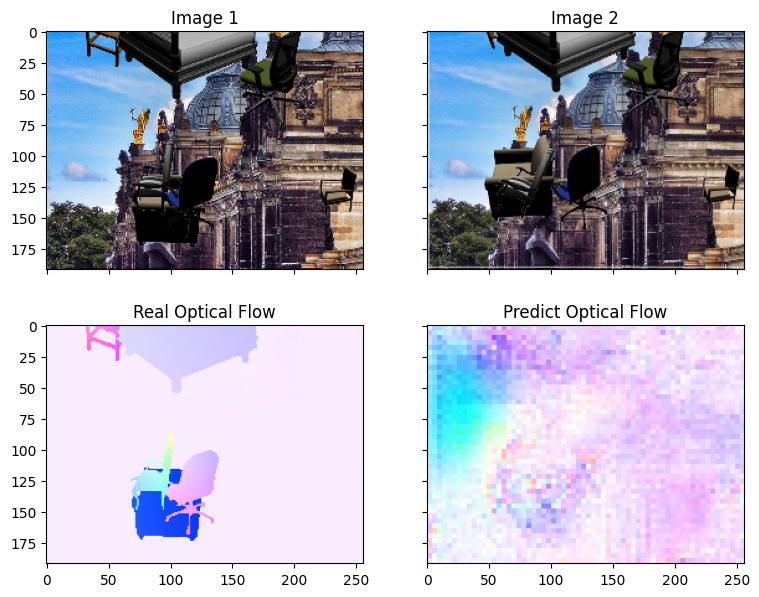

In [100]:
image_nums = list(range(4, 15))
for image_num in image_nums:
    fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, sharex=True, figsize=(9, 7))
    axs[0][0].imshow(test_dataset[image_num][0][0].permute(1,2,0).type('torch.LongTensor'))
    axs[0][0].set_title('Image 1')
    axs[0][1].imshow(test_dataset[image_num][0][1].permute(1,2,0).type('torch.LongTensor'))
    axs[0][1].set_title('Image 2')
    axs[1][0].imshow(flow_to_image(test_dataset[image_num][1]).permute(1,2,0).type('torch.LongTensor'))
    axs[1][0].set_title('Real Optical Flow')
    
    input = torch.cat(test_dataset[image_num][0], 1).to(device)
    predict_flow = model(input.reshape(1,6,192,256))
    predict_flow_inter = F.interpolate(predict_flow, (192,256))
    axs[1][1].imshow(flow_to_image(predict_flow_inter[0]).permute(1,2,0).type('torch.LongTensor'))
    axs[1][1].set_title('Predict Optical Flow')

    fig.savefig(f'plot {image_num}.png')

In [ ]:
model.cuda()

In [83]:
%%timeit -r 20 -n 5

input = torch.cat(test_dataset[3][0], 1).to(device)
predict_flow = model(input.reshape(1,6,192,256))

13.6 ms ± 567 µs per loop (mean ± std. dev. of 20 runs, 10 loops each)
